In [ ]:
# === METADATA CREATION ===

import os
import csv
import numpy as np
import pandas as pd
from PIL import Image, ExifTags
import shutil

# === CONFIGURATION ===
RAW_DIR             = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Test data"
OUTPUT_PATCH_DIR    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Patches"
METADATA_CSV        = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\metadata_October.csv"

# ROI configuration: per-photo fractions
# You can also load this from a CSV with columns: filename, x_min_frac, x_max_frac
ROI_FRAC_MAP = {
    "F2_0058.JPG":    (0.466, 0.699),
    "F9_0173.JPG":    (0.414, 0.674),
    "F13_0173.JPG":   (0.388, 0.648),
    "F15_0172.JPG":   (0.414, 0.622),
    "F16_0124.JPG":   (0.492, 0.725),
    "F18_0140.JPG":   (0.362, 0.544),
    "F19_0107.JPG":   (0.310, 0.570),
    "F21_0022.JPG":   (0.259, 0.570),
    # add your other photos here...
}
DEFAULT_ROI_FRAC = (0.0, 1.0)  # fallback: use full width

USE_ROI             = True
ROI_PATCH_DIR       = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\ROI_Patches"
ROI_METADATA_CSV    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\metadata_October_ROI.csv"

PATCH_SIZE          = 128
FLIGHT_ALTITUDE     = 35  # meters
SEASON              = "October"

# Mapping raw EXIF GPSAltitude to flight altitude (m)
ALTITUDE_MAP = {
    74: 25,
    69: 20,
    65: 15,
    70: 20,
    71: 20,
    84: 35
}
DEFAULT_ALTITUDE = 35  # fallback if no GPSAltitude or unmatched

os.makedirs(OUTPUT_PATCH_DIR, exist_ok=True)
if USE_ROI:
    os.makedirs(ROI_PATCH_DIR, exist_ok=True)

def dms_to_dd(dms, ref):
    deg, minute, sec = dms
    dd = float(deg) + float(minute)/60 + float(sec)/3600
    return -dd if ref in ['S','W'] else dd

def to_float(r):
    try:
        return float(r.numerator) / float(r.denominator)
    except:
        return float(r)

meta_records = []
roi_records = []

for fname in os.listdir(RAW_DIR):
    if not fname.lower().endswith(('.jpg','.jpeg','.png')):
        continue

    # Determine per-photo ROI fractions
    x_min_frac, x_max_frac = ROI_FRAC_MAP.get(fname, DEFAULT_ROI_FRAC)

    base, _ = os.path.splitext(fname)
    try:
        segment, photo_id = base.split('_', 1)
    except:
        segment, photo_id = base, ""

    img_path = os.path.join(RAW_DIR, fname)
    img = Image.open(img_path)
    width, height = img.size

    x_min = width * x_min_frac
    x_max = width * x_max_frac

    # EXIF extraction (focal length, GPS, etc.)
    gps_alt = None
    exif_data = {}
    raw_exif = img._getexif() or {}
    for tag, val in raw_exif.items():
        name = ExifTags.TAGS.get(tag, tag)
        if name == "FocalLength":
            exif_data['focal_length_mm'] = to_float(val)
        if name == "FocalLengthIn35mmFilm":
            exif_data['focal_length_35mm'] = to_float(val)
        if name == "FNumber":
            exif_data['f_number'] = to_float(val)
        if name == "ApertureValue":
            exif_data['aperture'] = to_float(val)
        if name == "GPSInfo":
            gps = {ExifTags.GPSTAGS.get(t, t): v for t, v in val.items()}
            if 'GPSLatitude' in gps and 'GPSLatitudeRef' in gps:
                gps_alt = to_float(gps['GPSAltitude'])
                exif_data['latitude'] = dms_to_dd(gps['GPSLatitude'], gps['GPSLatitudeRef'])
            if 'GPSLongitude' in gps and 'GPSLongitudeRef' in gps:
                exif_data['longitude'] = dms_to_dd(gps['GPSLongitude'], gps['GPSLongitudeRef'])

    # Map GPS altitude to flight altitude
    flight_altitude = ALTITUDE_MAP.get(int(round(gps_alt)) if gps_alt is not None else None,
                                       DEFAULT_ALTITUDE)                

    patch_id = 1
    for y in range(0, height, PATCH_SIZE):
        for x in range(0, width, PATCH_SIZE):
            if x + PATCH_SIZE > width or y + PATCH_SIZE > height:
                continue

            patch = img.crop((x, y, x+PATCH_SIZE, y+PATCH_SIZE))
            gray = np.array(patch.convert('L'))
            brightness_mean = float(gray.mean())
            brightness_std = float(gray.std())

            patch_filename = f"{segment}_{photo_id}_patch_{patch_id}.jpg"
            save_path = os.path.join(OUTPUT_PATCH_DIR, patch_filename)
            patch.save(save_path)

            record = {
                "patch_filename": patch_filename,
                "season": SEASON,
                "segment": segment,
                "photo_id": photo_id,
                "patch_id": patch_id,
                "x_start": x,
                "y_start": y,
                "patch_size": PATCH_SIZE,
                "flight_altitude": flight_altitude,
                "brightness_mean": brightness_mean,
                "brightness_std": brightness_std
            }
            record.update(exif_data)
            meta_records.append(record)

            # ROI subset based on per-photo fractions
            if USE_ROI and (x >= x_min and (x + PATCH_SIZE) <= x_max):
                shutil.copy(save_path, os.path.join(ROI_PATCH_DIR, patch_filename))
                roi_records.append(record)

            patch_id += 1

# Save metadata
pd.DataFrame(meta_records).to_csv(METADATA_CSV, index=False)
if USE_ROI:
    pd.DataFrame(roi_records).to_csv(ROI_METADATA_CSV, index=False)

print(f"Saved {len(meta_records)} total patches and {len(roi_records)} ROI patches.")


In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from roboflow import Roboflow
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
# === 0. CONFIG ===
METADATA_PATH = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\metadata_October_ROI.csv" 
TEST_PATCH_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Test_patches_resized"

# Roboflow settings
API_KEY = "hWGMaLWQuYEv0meKTn6j"
PROJECT_NAME = "thesis-8gv3k"  # Juiste projectnaam (kleine letters!!)
MODEL_VERSION = 8

# Output
PREDICTIONS_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv"

In [ ]:
# === 1. BUILD PATCH PATH MAP ===
patch_map = {}  # normalized_name -> (full_path, true_label_folder)
for class_name in os.listdir(TEST_PATCH_DIR):
    class_dir = os.path.join(TEST_PATCH_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        # normalize name by stripping off "_rf.<hash>" suffix
        base = os.path.splitext(img_file)[0]
        # split at "_rf" and append ".jpg"
        normalized = base.rsplit("_jpg", 1)[0] + ".jpg"
        full_path = os.path.join(class_dir, img_file)
        patch_map[normalized] = (full_path, class_name)

# === 2. Metadata laden ===
metadata = pd.read_csv(METADATA_PATH)

# === 3. Model laden ===
rf = Roboflow(api_key=API_KEY)
project = rf.workspace().project(PROJECT_NAME)
model = project.version(MODEL_VERSION).model

In [23]:
import time

# === 4. RUN PREDICTIONS ===
results = []
total_time = 0.0
n_samples = 0

for _, row in metadata.iterrows():
    patch_name = row["patch_filename"]
    entry = patch_map.get(patch_name)
    if entry is None:
        # patch not found
        results.append({
            "patch_filename": patch_name,
            "true_label": None,
            "pred_label": None,
            "confidence": None
        })
        continue

    patch_path, true_label = entry
    t0 = time.perf_counter()
    prediction = model.predict(patch_path)
    t1 = time.perf_counter()

    total_time += (t1 - t0)
    n_samples += 1

    pred_data = prediction.json().get("predictions", [])
    if pred_data:
        top = pred_data[0]
        pred_label = top["top"]
        confidence = top["confidence"]
    else:
        pred_label = None
        confidence = None

    results.append({
        "patch_filename": patch_name,
        "true_label": true_label,
        "pred_label": pred_label,
        "confidence": confidence
    })

In [ ]:
import pandas as pd
# Save the results list as a DataFrame to CSV
df_results = pd.DataFrame(results)
df_results.to_csv(PREDICTIONS_CSV, index=False)
print(f"Saved {len(df_results)} predictions to {PREDICTIONS_CSV}")

## control on true label + empty prediction

In [8]:
import os
import pandas as pd

# === CONFIGURATION ===
TEST_PATCH_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Test_patches_resized"
FULL_META_CSV  = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\new_model_try.csv"

# 1. Build folder-derived true_map
true_map = {}
for cls in os.listdir(TEST_PATCH_DIR):
    cls_dir = os.path.join(TEST_PATCH_DIR, cls)
    if not os.path.isdir(cls_dir):
        continue
    for fn in os.listdir(cls_dir):
        base = os.path.splitext(fn)[0].split("_jpg")[0] + ".jpg"
        true_map[base] = cls

# 2. Load your merged July metadata
df = pd.read_csv(FULL_META_CSV)

# 3. Compare
df['derived_true'] = df['patch_filename'].map(true_map)
mismatches = df[df['derived_true'] != df['true_label']]

print(f"Total patches: {len(df)}")
print(f"Mismatches:   {len(mismatches)} ({len(mismatches)/len(df)*100:.2f}%)")

if not mismatches.empty:
    print("\nFirst 10 mismatches:")
    print(mismatches[['patch_filename','true_label','derived_true']].head(10))

    # Save for deeper inspection
    out_dir = os.path.join(os.path.dirname(FULL_META_CSV), "debug_mismatches")
    os.makedirs(out_dir, exist_ok=True)
    mismatches.to_csv(os.path.join(out_dir, "july_true_label_mismatches.csv"), index=False)
    print(f"\nMismatch details saved to: {out_dir}")


Total patches: 2100
Mismatches:   0 (0.00%)


In [9]:
df_results = pd.DataFrame(results)
mask_empty = df_results['pred_label'].astype(str).str.strip() == ""
df_results[mask_empty]


,patch_filename,true_label,pred_label,confidence
399,F15_0172_patch_760.jpg,Common reed,,0.0
650,F16_0124_patch_885.jpg,Common reed,,0.0
661,F16_0124_patch_929.jpg,Common reed,,0.0
669,F16_0124_patch_970.jpg,Common reed,,0.0
698,F16_0124_patch_1131.jpg,Common reed,,0.0
1050,F19_0107_patch_506.jpg,Other,,0.0
1875,F9_0173_patch_224.jpg,Duckweed,,0.0


In [10]:
import pandas as pd

# Assuming df_results is already loaded
# Example loading:
# df_results = pd.read_csv("predictions_output.csv")
df_results = pd.DataFrame(results)

# 1. Compute mean confidence per class (excluding None values)
class_mean_conf = df_results[df_results['confidence'].notnull()].groupby('true_label')['confidence'].mean()

# 2. Identify rows with missing predictions
mask_missing = df_results['pred_label'].astype(str).str.strip() == ""

# 3. Fill pred_label with the true_label for those rows
df_results.loc[mask_missing, 'pred_label'] = df_results.loc[mask_missing, 'true_label']

# 4. Fill missing confidence using the class‐mean confidence
df_results.loc[mask_missing, 'confidence'] = df_results.loc[mask_missing, 'true_label'].map(class_mean_conf)

# 5. (Optional) Save back to CSV
df_results.to_csv(PREDICTIONS_CSV, index=False)
print(f"Saved {len(df_results)} predictions to {PREDICTIONS_CSV}")
print(f"Avg inference time: {total_time / max(n_samples,1):.3f}s per patch")

# Display the updated rows
df_results[mask_missing]


Saved 2100 predictions to C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\new_model_try.csv
Avg inference time: 0.433s per patch


,patch_filename,true_label,pred_label,confidence
399,F15_0172_patch_760.jpg,Common reed,Common reed,0.928799
650,F16_0124_patch_885.jpg,Common reed,Common reed,0.928799
661,F16_0124_patch_929.jpg,Common reed,Common reed,0.928799
669,F16_0124_patch_970.jpg,Common reed,Common reed,0.928799
698,F16_0124_patch_1131.jpg,Common reed,Common reed,0.928799
1050,F19_0107_patch_506.jpg,Other,Other,0.957072
1875,F9_0173_patch_224.jpg,Duckweed,Duckweed,0.881199


## ViT Evaluation


=== Evaluation Metrics ===
Accuracy: 0.6733
Macro F1 Score: 0.6828

                precision    recall  f1-score   support

   Clear Water       0.94      0.67      0.79       460
   Common reed       0.86      0.50      0.63       642
      Duckweed       0.97      0.57      0.72       273
         Other       0.52      0.83      0.64       484
Water-starwort       0.48      0.94      0.64       241

      accuracy                           0.67      2100
     macro avg       0.76      0.70      0.68      2100
  weighted avg       0.77      0.67      0.68      2100



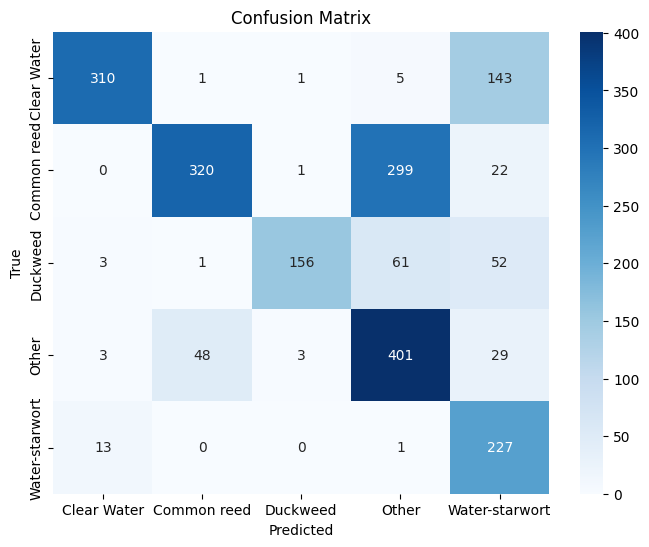

In [11]:
# === 5. Evaluatie ===
y_true = df_results['true_label']
y_pred = df_results['pred_label']

print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}\n")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Check for unexpected labels
print("Unique true labels:", sorted(df_results['true_label'].unique()))
print("Unique predicted labels:", sorted(df_results['pred_label'].unique()))

Unique true labels: ['Clear Water', 'Common reed', 'Duckweed', 'Other', 'Water-starwort']
Unique predicted labels: ['Clear Water', 'Common reed', 'Duckweed', 'Other', 'Water-starwort']


## ViT wrong patches

In [ ]:
import os
import pandas as pd
import shutil

# === CONFIGURATION ===
PREDICTIONS_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv"
TEST_PATCH_DIR  = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Test_patches_resized"
WRONG_DIR       = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\October_wrong_predictions"

# Create output directory
os.makedirs(WRONG_DIR, exist_ok=True)

# --- 1. Load predictions DataFrame ---
df = pd.read_csv(PREDICTIONS_CSV)

# --- 2. Build mapping: normalized patch_name -> full image path ---
patch_map = {}
for class_name in os.listdir(TEST_PATCH_DIR):
    class_dir = os.path.join(TEST_PATCH_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        # normalize by removing '_rf.<hash>' and keeping extension .jpg
        base = os.path.splitext(img_file)[0]
        normalized = base.rsplit("_jpg", 1)[0] + ".jpg"
        patch_map[normalized] = os.path.join(class_dir, img_file)

# --- 3. Iterate wrong predictions and copy to folders ---
wrong_rows = df[df['true_label'] != df['pred_label']]
for _, row in wrong_rows.iterrows():
    patch_name = row['patch_filename']
    true_cls = row['true_label']
    pred_cls = row['pred_label']
    src_path = patch_map.get(patch_name)
    if not src_path or not os.path.exists(src_path):
        print(f"Warning: file not found for {patch_name}")
        continue

    # Create subfolder for this truth→prediction
    subfolder = f"{true_cls}_to_{pred_cls}"
    dst_dir = os.path.join(WRONG_DIR, subfolder)
    os.makedirs(dst_dir, exist_ok=True)

    # Copy image
    shutil.copy(src_path, os.path.join(dst_dir, os.path.basename(src_path)))

print(f"Copied {len(wrong_rows)} wrong predictions into {WRONG_DIR}")


Copied 644 wrong predictions into C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\October_wrong_predictions


## Analysis of predictions of VGG16 and ViT

In [ ]:
## Analysis of predictions for VGG16 and ViT ##

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# === 0. CONFIGURATION ===
models_info = {
    "vgg16": {
        "csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\vgg16\confidence_scores.csv",
        "analysis_dir": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\vgg16\analysis"
    },
    "ViT": {
        "csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv",
        "analysis_dir": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\analysis"
    }
}

# Ensure analysis directories exist
for info in models_info.values():
    os.makedirs(info["analysis_dir"], exist_ok=True)

# === 1. ANALYSIS PER MODEL ===
metrics_summary = []
per_class_f1 = {}

for name, info in models_info.items():
    # Load and normalize columns
    df = pd.read_csv(info["csv"])
    if name == "vgg16":
        df = df.rename(columns={"true": "true", "pred": "pred"})[["true","pred","confidence"]]
    else:
        df = df.rename(columns={"true_label":"true", "pred_label":"pred"})[["true","pred","confidence"]]
    
    # Compute aggregate metrics
    acc = accuracy_score(df["true"], df["pred"])
    mac_f1 = f1_score(df["true"], df["pred"], average="macro")
    wei_f1 = f1_score(df["true"], df["pred"], average="weighted")
    prec = precision_score(df["true"], df["pred"], average="macro")
    rec = recall_score(df["true"], df["pred"], average="macro")
    
    # Save summary metrics
    metrics_summary.append({
        "model": name,
        "accuracy": acc,
        "macro_f1": mac_f1,
        "weighted_f1": wei_f1,
        "precision_macro": prec,
        "recall_macro": rec
    })
    pd.DataFrame([metrics_summary[-1]]).to_csv(
        os.path.join(info["analysis_dir"], "metrics_summary.csv"), index=False
    )
    
    # Classification report
    report = classification_report(df["true"], df["pred"], digits=4)
    with open(os.path.join(info["analysis_dir"], "classification_report.txt"), "w") as f:
        f.write(report)
    
    # Confusion matrix
    labels = sorted(df["true"].unique())
    cm = confusion_matrix(df["true"], df["pred"], labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.to_csv(os.path.join(info["analysis_dir"], "confusion_matrix.csv"))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", square=True)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(info["analysis_dir"], "confusion_matrix.png"))
    plt.close()
    
    # Per-class F1
    f1s = []
    for cls in labels:
        f1s.append(f1_score(df["true"], df["pred"], labels=[cls], average="macro"))
    per_class_f1[name] = {"classes": labels, "f1s": f1s}
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=labels, y=f1s, palette="viridis")
    plt.title(f"{name} Per-Class F1 Score")
    plt.ylabel("F1 Score")
    plt.ylim(0,1)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(info["analysis_dir"], "per_class_f1.png"))
    plt.close()
    
    # Confidence distributions
    plt.figure(figsize=(8,5))
    sns.histplot(df["confidence"], bins=20, kde=True)
    plt.title(f"{name} Confidence Distribution")
    plt.xlabel("Confidence")
    plt.tight_layout()
    plt.savefig(os.path.join(info["analysis_dir"], "confidence_distribution.png"))
    plt.close()
    
    df["correct"] = df["true"] == df["pred"]
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x="confidence", hue="correct", bins=20, kde=True, palette={True:"green",False:"red"})
    plt.title(f"{name} Confidence: Correct vs Incorrect")
    plt.xlabel("Confidence")
    plt.tight_layout()
    plt.savefig(os.path.join(info["analysis_dir"], "confidence_correct_vs_incorrect.png"))
    plt.close()

# === 2. COMPARISON PLOTS ===
# Summary metrics table
metrics_df = pd.DataFrame(metrics_summary)
metrics_df.to_csv(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\metrics_comparison.csv", index=False)

# Bar plot: Accuracy and Macro F1 comparison
plt.figure(figsize=(6,4))
x = np.arange(len(metrics_df))
width = 0.35
plt.bar(x - width/2, metrics_df["accuracy"], width, label="Accuracy", color="skyblue")
plt.bar(x + width/2, metrics_df["macro_f1"], width, label="Macro F1", color="steelblue")
plt.xticks(x, metrics_df["model"])
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs Macro F1")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\model_comparison_metrics.png")
plt.close()

# Combined per-class F1 comparison
plt.figure(figsize=(10,6))
classes = per_class_f1["vgg16"]["classes"]
x = np.arange(len(classes))
width = 0.35
plt.bar(x - width/2, per_class_f1["vgg16"]["f1s"], width, label="VGG16", color="blue")
plt.bar(x + width/2, per_class_f1["ViT"]["f1s"], width, label="ViT", color="green")
plt.xticks(x, classes, rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.title("Per-Class F1: VGG16 vs ViT")
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\per_class_f1_comparison.png")
plt.close()


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

# === 0. CONFIGURATION ===
# Fill in your actual file paths here
results = {
    "vgg16": {
        "July": {
            "pred_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\confidence_scores.csv",
            "confmat_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\vgg16\benchmark_confusion_matrix.csv"
        },
        "October": {
            "pred_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\vgg16\confidence_scores.csv",
            "confmat_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\vgg16\analysis\confusion_matrix.csv"
        }
    },
    "ViT": {
        "July": {
            "pred_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\predictions_output.csv",
            "confmat_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\ViT\confusion_matrix.csv"
        },
        "October": {
            "pred_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv",
            "confmat_csv": r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\analysis\confusion_matrix.csv"
        }
    }
}

output_dir = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\comparison"
os.makedirs(output_dir, exist_ok=True)

# === 1. AGGREGATE MACRO-F1 TABLE ===
macro_f1 = []
for model, seasons in results.items():
    for season, paths in seasons.items():
        df = pd.read_csv(paths["pred_csv"])
        # normalize column names
        if model=="vgg16":
            y_true = df["true"]
            y_pred = df["pred"]
        else:
            y_true = df["true_label"]
            y_pred = df["pred_label"]
        m = f1_score(y_true, y_pred, average="macro")
        macro_f1.append({"model": model, "season": season, "macro_f1": m})
macro_df = pd.DataFrame(macro_f1)
macro_df.to_csv(os.path.join(output_dir, "macro_f1_comparison.csv"), index=False)

# Plot grouped bar
plt.figure(figsize=(6,4))
sns.barplot(data=macro_df, x="season", y="macro_f1", hue="model", palette=["blue","green"])
plt.ylim(0,1)
plt.ylabel("Macro F₁ Score")
plt.title("Macro F₁ by Model and Season")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "macro_f1_by_season.png"))
plt.close()

# === 2. PER-CLASS F1 HEATMAP ===
for model, seasons in results.items():
    classes = None
    f1_matrix = {}
    for season, paths in seasons.items():
        df = pd.read_csv(paths["pred_csv"])
        if model=="vgg16":
            y_true = df["true"]
            y_pred = df["pred"]
        else:
            y_true = df["true_label"]
            y_pred = df["pred_label"]
        # compute per-class f1
        cls = sorted(y_true.unique())
        classes = cls
        f1s = []
        for c in cls:
            f1s.append(f1_score(y_true, y_pred, labels=[c], average="macro"))
        f1_matrix[season] = f1s
    heat_df = pd.DataFrame(f1_matrix, index=classes)
    heat_df.to_csv(os.path.join(output_dir, f"{model}_per_class_f1.csv"))
    plt.figure(figsize=(6,5))
    sns.heatmap(heat_df, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1)
    plt.title(f"{model} Per-Class F₁ Across Seasons")
    plt.ylabel("Class")
    plt.xlabel("Season")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model}_per_class_f1_heatmap.png"))
    plt.close()

# === 3. DELTA F1 BAR CHART ===
delta = []
for model, df in results.items():
    # load per-class f1 data
    f = pd.read_csv(os.path.join(output_dir, f"{model}_per_class_f1.csv"), index_col=0)
    delta_vals = f["October"] - f["July"]
    for cls, dv in delta_vals.items():
        delta.append({"model": model, "class": cls, "delta_f1": dv})
delta_df = pd.DataFrame(delta)
delta_df.to_csv(os.path.join(output_dir, "delta_f1.csv"), index=False)

plt.figure(figsize=(8,4))
sns.barplot(data=delta_df, x="class", y="delta_f1", hue="model", palette=["blue","green"])
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Δ F₁ (Oct − July)")
plt.xticks(rotation=45, ha="right")
plt.title("Change in Per-Class F₁ from July to October")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "delta_f1_per_class.png"))
plt.close()

# === 4. CONFUSION MATRIX DIFFERENCE ===
for model, seasons in results.items():
    cm_j = pd.read_csv(seasons["July"]["confmat_csv"], index_col=0)
    cm_o = pd.read_csv(seasons["October"]["confmat_csv"], index_col=0)
    diff = cm_o - cm_j
    diff.to_csv(os.path.join(output_dir, f"{model}_confmat_diff.csv"))
    plt.figure(figsize=(6,5))
    sns.heatmap(diff, annot=True, center=0, cmap="vlag", fmt="d")
    plt.title(f"{model} Confusion Matrix Difference (Oct−July)")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model}_confmat_diff.png"))
    plt.close()



## Merge predictions with metadata

In [2]:
import os
import pandas as pd
import numpy as np

# === CONFIGURATION ===
METADATA_CSV      = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\metadata_October_ROI.csv"
VIT_PRED_CSV      = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv"
OUTPUT_MERGED_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\metadata_with_predictions.csv"

# Optional: class-specific brightness thresholds for sun/shadow assignment
brightness_thresholds = {
    "Clear Water": 55,
    "Common reed": 60,
    "Duckweed": 70,
    "Other": 50,
    "Water-starwort": 50
}

# === 1. LOAD METADATA & PREDICTIONS ===
df_meta = pd.read_csv(METADATA_CSV)
df_pred = pd.read_csv(VIT_PRED_CSV)

# Normalize column names
df_pred = df_pred.rename(columns={
    "true_label": "true_label",
    "pred_label": "pred_label",
    "confidence": "confidence",
    "patch_filename": "patch_filename"
})

# === 2. MERGE ON patch_filename ===
df = pd.merge(df_meta, df_pred[['patch_filename','true_label','pred_label','confidence']],
              on="patch_filename", how="left")

# === 3. ASSIGN LIGHT CONDITION ===
# If using a global threshold:
global_thresh = df['brightness_mean'].median()
#df['light_condition'] = np.where(df['brightness_mean'] < global_thresh, 'shadow', 'sun')

# Assign light_condition based on class-specific brightness thresholds
df['light_condition'] = df.apply(
    lambda row: 'shadow' if row['brightness_mean'] < brightness_thresholds.get(row['true_label'], global_thresh) else 'sun',
    axis=1
)

df["ImageWidth"] = 5280
df["ImageLength"] = 3956

# === 4. SAVE MERGED CSV ===
os.makedirs(os.path.dirname(OUTPUT_MERGED_CSV), exist_ok=True)
df.to_csv(OUTPUT_MERGED_CSV, index=False)
print(f"Saved merged metadata with predictions to {OUTPUT_MERGED_CSV}")


Saved merged metadata with predictions to C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\metadata_with_predictions.csv


## Control

In [8]:
import os
import pandas as pd

# === CONFIGURATION ===
TEST_PATCH_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Test_patches_resized"
PRED_CSV       = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\predictions_output.csv"
META_CSV       = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\metadata_with_predictions.csv"

# === 1. Build true_map from folder structure ===
true_map = {}
for cls in os.listdir(TEST_PATCH_DIR):
    cls_dir = os.path.join(TEST_PATCH_DIR, cls)
    if not os.path.isdir(cls_dir):
        continue
    for fn in os.listdir(cls_dir):
        # normalize filename by stripping any _rf hash suffix
        base = os.path.splitext(fn)[0].split("_jpg")[0] + ".jpg"
        true_map[base] = cls

# === 2. Load CSVs ===
df_pred = pd.read_csv(PRED_CSV)
df_meta = pd.read_csv(META_CSV)

# Ensure 'patch_filename' column
for df in (df_pred, df_meta):
    if 'patch_filename' not in df.columns:
        raise KeyError(f"'patch_filename' not found in {df}")

# === 3. Compare true_label in both DataFrames ===
def compare_truth(df, filename_column, true_column):
    df['derived_true'] = df[filename_column].map(true_map)
    mismatch = df[df['derived_true'] != df[true_column]]
    total = len(df)
    mismatches = len(mismatch)
    pct = mismatches / total * 100
    return mismatch, total, mismatches, pct

# Predictions CSV comparison
m_pred, tot_pred, mis_pred, pct_pred = compare_truth(df_pred, 'patch_filename', 'true_label')
print(f"Predictions CSV: {mis_pred}/{tot_pred} mismatches ({pct_pred:.2f}%)")

# Metadata CSV comparison
m_meta, tot_meta, mis_meta, pct_meta = compare_truth(df_meta, 'patch_filename', 'true_label')
print(f"Metadata CSV:    {mis_meta}/{tot_meta} mismatches ({pct_meta:.2f}%)")

# === 4. Output mismatches for inspection ===
OUT_DIR = os.path.join(os.path.dirname(PRED_CSV), "mismatch_inspection")
os.makedirs(OUT_DIR, exist_ok=True)

m_pred.to_csv(os.path.join(OUT_DIR, "predictions_mismatches.csv"), index=False)
m_meta.to_csv(os.path.join(OUT_DIR, "metadata_mismatches.csv"), index=False)

print("Mismatch rows saved to:", OUT_DIR)


Predictions CSV: 0/2100 mismatches (0.00%)
Metadata CSV:    0/2100 mismatches (0.00%)
Mismatch rows saved to: C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\mismatch_inspection


## Brighntess

In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image

# === CONFIGURATION ===
PATCH_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Test_patches_original"
OUTPUT_CSV = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\brightness_by_patch.csv"

# === 1. COLLECT BRIGHTNESS FOR EACH PATCH ===
records = []
for class_name in os.listdir(PATCH_DIR):
    class_dir = os.path.join(PATCH_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path).convert("L")
        brightness_mean = float(np.array(img).mean())
        records.append({
            "patch_filename": img_file,
            "class": class_name,
            "brightness_mean": brightness_mean
        })

# === 2. CREATE DATAFRAME & SAVE ===
df_brightness = pd.DataFrame(records)
df_brightness.to_csv(OUTPUT_CSV, index=False)


# Show summary statistics per class
summary = df_brightness.groupby("class")["brightness_mean"].describe().round(2)
print("Brightness Summary by Class:")
print(summary)


Brightness Summary by Class:
                count    mean    std    min    25%     50%     75%     max
class                                                                     
Clear Water     460.0   46.86  21.27   5.79  38.14   48.73   58.50  146.86
Common reed     642.0   67.87  37.00  10.69  34.45   62.95   98.32  174.35
Duckweed        273.0  111.48  40.35  12.47  90.11  130.20  140.67  157.91
Other           484.0   74.93  38.37   9.75  41.89   75.30  108.60  201.41
Water-starwort  241.0   43.98  14.45  11.39  35.32   40.27   51.86   93.16


## Mapping patches back

In [ ]:
import os
import math
import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd

# === CONFIGURATION ===
METADATA_PATH     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\metadata_with_predictions.csv"
OUTPUT_GEOJSON    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\patch_footprints.geojson"

# Camera sensor dimensions (mm) – replace with your camera's actual specs
SENSOR_WIDTH_MM   = 13.2
SENSOR_HEIGHT_MM  = 8.8

# Constants for lat/lon conversion
METERS_PER_DEG_LAT = 111320.0

# === 1. LOAD METADATA ===
df = pd.read_csv(METADATA_PATH)

# Ensure required columns exist
required = ["latitude","longitude","focal_length_mm","ImageWidth","ImageLength","x_start","y_start","patch_size"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in metadata: {missing}")

# === 2. COMPUTE GSD (m/px) per row ===
df["pitch_x_mm"] = SENSOR_WIDTH_MM / df["ImageWidth"]
df["pitch_y_mm"] = SENSOR_HEIGHT_MM / df["ImageLength"]
df["GSD_x"] = df["flight_altitude"] * df["pitch_x_mm"] / df["focal_length_mm"]
df["GSD_y"] = df["flight_altitude"] * df["pitch_y_mm"] / df["focal_length_mm"]

# Precompute cos(lat) factor
df["cos_lat"] = np.cos(np.deg2rad(df["latitude"]))

# === 3. FUNCTION TO COMPUTE PATCH POLYGON GEOFOOTPRINT ===
def compute_footprint(row):
    x0, y0, ps = row["x_start"], row["y_start"], row["patch_size"]
    # define pixel corners (image coords: origin top-left, y down)
    pix_corners = [(x0, y0), (x0+ps, y0), (x0+ps, y0+ps), (x0, y0+ps)]
    geo_coords = []
    for px, py in pix_corners:
        # offsets from image center
        dx = (px - row["ImageWidth"]/2) * row["GSD_x"]
        dy = -(py - row["ImageLength"]/2) * row["GSD_y"]
        # convert to lat/lon
        lat = row["latitude"] + dy / METERS_PER_DEG_LAT
        lon = row["longitude"] + dx / (METERS_PER_DEG_LAT * row["cos_lat"])
        geo_coords.append((lon, lat))
    # build bounding box from coords
    minx = min(pt[0] for pt in geo_coords)
    maxx = max(pt[0] for pt in geo_coords)
    miny = min(pt[1] for pt in geo_coords)
    maxy = max(pt[1] for pt in geo_coords)
    return box(minx, miny, maxx, maxy)

# === 4. CREATE GeoDataFrame AND SAVE ===
gdf = gpd.GeoDataFrame(
    df,
    geometry=df.apply(compute_footprint, axis=1),
    crs="EPSG:4326"
)
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")
print(f"Saved patch footprints to {OUTPUT_GEOJSON}")


In [ ]:
import os
import math
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import box
import geopandas as gpd

# === CONFIGURATION ===
DEM_PATH         = r"C:\[…]\dem.tif"                # your Metashape‐exported DEM
METADATA_PATH     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\metadata_with_predictions.csv"
OUTPUT_GEOJSON    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\patch_footprints.geojson"

# Constants
DEG_TO_M_LAT     = 111320.0      # m per degree latitude

# === 1. LOAD INPUTS ===
df = pd.read_csv(METADATA_PATH)
dem = rasterio.open(DEM_PATH)
dem_arr = dem.read(1)
dem_tf  = dem.transform

# helper to sample DEM elevation at lon/lat
def sample_dem(lon, lat):
    row, col = dem.index(lon, lat)
    return float(dem_arr[row, col])

# === 2. DERIVE SENSOR SIZE FROM EXIF ===
# If your metadata has 'ImageWidth', 'ImageLength', 'focal_length_mm', 'focal_length_35mm'
diag35 = 43.27  # 35mm diagonal in mm
w_px = df['ImageWidth']
h_px = df['ImageLength']
f_mm = df['focal_length_mm']
f35   = df['focal_length_35mm']

# sensor diagonal (mm) from ratio of focal lengths
df['sensor_diag_mm']  = f_mm / f35 * diag35
# aspect ratio
df['aspect']          = w_px / h_px
# sensor height & width (mm)
df['sensor_h_mm']     = df['sensor_diag_mm'] / np.sqrt(df['aspect']**2 + 1)
df['sensor_w_mm']     = df['sensor_h_mm'] * df['aspect']

# === 3. COMPUTE ALTITUDE ABOVE GROUND (AGL) ===
# assume your metadata GPSAltitude column is "flight_altitude_masl"
df['ground_elev'] = df.apply(lambda r: sample_dem(r['longitude'], r['latitude']), axis=1)
df['altitude_agl'] = df['flight_altitude_masl'] - df['ground_elev']

# === 4. COMPUTE GSD (m/px) ===
df['pitch_x_mm'] = df['sensor_w_mm'] / w_px
df['pitch_y_mm'] = df['sensor_h_mm'] / h_px
df['GSD_x']      = df['altitude_agl'] * df['pitch_x_mm'] / f_mm
df['GSD_y']      = df['altitude_agl'] * df['pitch_y_mm'] / f_mm
df['cos_lat']    = np.cos(np.deg2rad(df['latitude']))

# === 5. BUILD PATCH POLYGONS ===
polys = []
for _, r in df.iterrows():
    x0, y0, ps = r['x_start'], r['y_start'], r['patch_size']
    corners = [
        (x0,    y0),
        (x0+ps, y0),
        (x0+ps, y0+ps),
        (x0,    y0+ps)
    ]
    geo = []
    for px, py in corners:
        dx = (px - w_px.loc[_]/2) * r['GSD_x']
        dy = -(py - h_px.loc[_]/2) * r['GSD_y']
        lat = r['latitude'] + dy / DEG_TO_M_LAT
        lon = r['longitude'] + dx / (DEG_TO_M_LAT * r['cos_lat'])
        geo.append((lon, lat))
    polys.append(box(*(
        min(pt[0] for pt in geo),
        min(pt[1] for pt in geo),
        max(pt[0] for pt in geo),
        max(pt[1] for pt in geo)
    )))

# === 6. EXPORT GEOJSON ===
gdf = gpd.GeoDataFrame(df, geometry=polys, crs="EPSG:4326")
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")
print("Saved GSD-based footprints to:", OUTPUT_GEOJSON)


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import Polygon
import geopandas as gpd

# === CONFIGURATION ===
CAMERAS_JSON    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\photogrammetry\cameras.json"
DEM_PATH        = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\orthomosaic\dem.tif"
METADATA_CSV     = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\metadata_with_predictions.csv"
OUTPUT_GEOJSON    = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_October\Results\ViT\patch_footprints.geojson"



# === LOAD DATA ===
df_meta = pd.read_csv(METADATA_CSV)
with open(CAMERAS_JSON, 'r') as f:
    cameras = {cam['filename']: cam for cam in json.load(f)}

dem = rasterio.open(DEM_PATH)
dem_arr = dem.read(1)
dem_affine = dem.transform  # Affine transformation

# === HELPER FUNCTIONS ===
def dem_elevation(lon, lat):
    """Sample DEM at given lon/lat."""
    row, col = dem.index(lon, lat)
    return float(dem_arr[row, col])

def pixel_to_world(cam, u, v, z_elev):
    """
    collinearity:
    Given camera intrinsics/extrinsics and a pixel (u,v) and ground Z,
    return (X,Y).
    """
    fx, fy = cam['fx'], cam['fy']
    cx, cy = cam['cx'], cam['cy']
    R = np.array(cam['R'])  # 3x3
    t = np.array(cam['t']).reshape(3)  # translation (m)

    # camera center in world coords: C = -R^T t
    C = -R.T @ t

    # normalized image coords
    x = (u - cx) / fx
    y = (v - cy) / fy
    ray_cam = np.array([x, y, 1.0])
    # ray in world coords
    ray_world = R.T @ ray_cam  # direction

    # solve for s: C_z + s*ray_z = z_elev
    s = (z_elev - C[2]) / ray_world[2]
    P = C + s * ray_world
    return P[0], P[1]

# === COMPUTE PATCH FOOTPRINTS ===
polygons = []
for idx, row in df_meta.iterrows():
    img_file = f"{row['segment']}_{row['photo_id']}.JPG"
    cam = cameras.get(img_file)
    if cam is None:
        continue

    # corners in pixel coords
    x0, y0 = row['x_start'], row['y_start']
    ps = row['patch_size']
    corners_px = [
        (x0, y0),
        (x0+ps, y0),
        (x0+ps, y0+ps),
        (x0, y0+ps)
    ]

    # first estimate center lon/lat for DEM sampling
    # using latitude/longitude from metadata (image center)
    z_ground = dem_elevation(row['longitude'], row['latitude'])

    # compute world coords for each corner
    world_pts = [pixel_to_world(cam, u, v, z_ground) for u, v in corners_px]
    poly = Polygon(world_pts)
    poly_record = row.to_dict()
    poly_record['geometry'] = poly
    polygons.append(poly_record)

# === SAVE AS GeoJSON ===
gdf = gpd.GeoDataFrame(polygons, crs=dem.crs)
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")



[
  {
    "filename": "F2_0058.JPG",
    "width": 4000,
    "height": 3000,
    "fx": 3124.5,
    "fy": 3126.1,
    "cx": 1998.7,
    "cy": 1502.3,
    "k1": -0.214,
    "k2":  0.136,
    "p1":  0.0002,
    "p2": -0.0001,
    "R": [
      [ 0.998, -0.045,  0.035],
      [ 0.046,  0.998, -0.030],
      [-0.034,  0.031,  0.999]
    ],
    "t": [ 123.45,  67.89,  25.43 ]
  },
  {
    "filename": "F2_0059.JPG",
    "...": "..."
  },
  …
]

Open your F2 project in Metashape (or Pix4D, COLMAP—whichever you used) that contains your segment-F2 images, the dense point cloud, the DEM/DSM and the orthomosaic.

Export Cameras (with intrinsics & extrinsics):

In Metashape: Workflow ▸ Export ▸ Export Cameras… choose JSON or XML. This file (let’s call it cameras.json) will contain one entry per source image (e.g. F2_0058.JPG, F2_0060.JPG, etc.) with fields like fx, fy, cx, cy, R, t.

In COLMAP: run the model_converter command to output cameras.json and images.json, then merge intrinsics and extrinsics based on filename/image_id.

Export DEM in the same CRS:

In Metashape: Workflow ▸ Export DEM… (GeoTIFF) or DSM if you prefer surface height. That gives you dem.tif.

This DEM is already in the exact coordinate frame as your orthomosaic because it was generated from the same bundle adjustment and GCPs.

Run the collinearity‐based Python script I provided earlier, pointing it to:

metadata_with_predictions.csv (which tells you each patch’s source image name plus x_start, y_start, patch_size).

cameras.json (so it can look up intrinsics & the precise camera pose for that image).

dem.tif (so it can sample the true ground elevation under each patch).